# MLP

Use MLP of size 256, 128, 64 and relu activation. 

Use Splitter2.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 09:41:59.195356
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

ALPHABET_SIZE=4
K=4
VOCABULARY_SIZE = ALPHABET_SIZE**K 
from TrainValidSplit2 import Splitter2
EPOCHS=10
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    act='relu'
    dense1_layer = keras.layers.Dense(256, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(128, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(64, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation='sigmoid',dtype=dt)

    mlp = keras.models.Sequential()
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
def do_cross_validation(splitter,eps):
    cv_scores = []
    fold=0
    data_partitions = splitter.get_train_valid_partitions(universe)
    for one_partition in data_partitions:
        train_genes,valid_genes = one_partition[0],one_partition[1]
        thresholds = splitter.choose_thresholds(train_genes)
        X_train,y_train = splitter.get_X_y(train_genes, thresholds)
        X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)

        fold += 1
        print('Fold',fold)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=eps, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )
                        
        print("Fold %d, %d epochs"%(fold,eps))

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)
    print()
    print("Validation core mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))


## Train and validate

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 09:42:11.826749
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 09:42:14.890936


In [8]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 09:42:14.898916
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 107,009
Trainable params: 107,009
Non-trainable params: 0
_________________________________________________________________
None


2022-10-20 09:42:14.925409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cross valiation
2022-10-20 09:42:15.131565
Fold 1
Train set ones/size 22203 / 43098
Valid set ones/size 6149 / 11253
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1347/1347 [==============================] - 5s 3ms/step - loss: 0.6099 - accuracy: 0.6883 - val_loss: 0.5797 - val_accuracy: 0.7070
Epoch 2/10
1347/1347 [==============================] - 4s 3ms/step - loss: 0.5587 - accuracy: 0.7200 - val_loss: 0.5860 - val_accuracy: 0.6947
Epoch 3/10
1347/1347 [==============================] - 4s 3ms/step - loss: 0.5401 - accuracy: 0.7321 - val_loss: 0.5868 - val_accuracy: 0.7009
Epoch 4/10
1347/1347 [==============================] - 4s 3ms/step - loss: 0.5255 - accuracy: 0.7430 - val_loss: 0.5918 - val_accuracy: 0.6994
Epoch 5/10
1347/1347 [==============================] - 4s 3ms/step - loss: 0.4966 - accuracy: 0.7605 - val_loss: 0.6011 - val_accuracy: 0.7004
Epoch 6/10
1347/1347 [==============================] - 4s 3ms/step - loss: 0.4703 - accuracy: 0.7770 - val_loss: 0.6647 - v

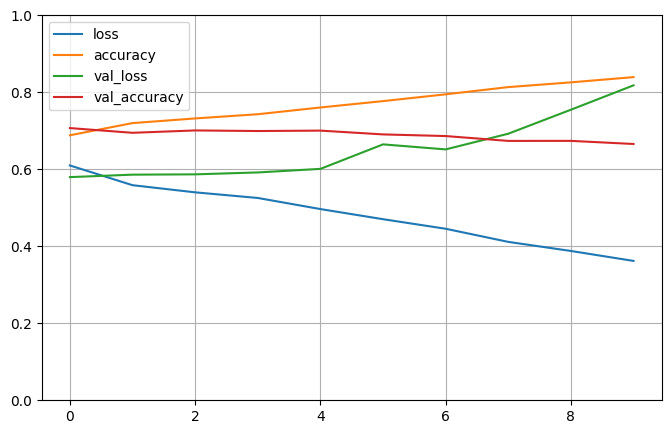

accuracy: 66.57%
Fold 2
Train set ones/size 22392 / 43483
Valid set ones/size 5710 / 10868
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1359/1359 [==============================] - 5s 3ms/step - loss: 0.6078 - accuracy: 0.6920 - val_loss: 0.6165 - val_accuracy: 0.6806
Epoch 2/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.5589 - accuracy: 0.7149 - val_loss: 0.5976 - val_accuracy: 0.6881
Epoch 3/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.5377 - accuracy: 0.7308 - val_loss: 0.5998 - val_accuracy: 0.6971
Epoch 4/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.5224 - accuracy: 0.7403 - val_loss: 0.6211 - val_accuracy: 0.6814
Epoch 5/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.4909 - accuracy: 0.7617 - val_loss: 0.6504 - val_accuracy: 0.6843
Epoch 6/10
1359/1359 [==============================] - 4s 3ms/step - loss: 0.4610 - accuracy: 0.7820 - val_loss: 0.6820 - val_accuracy: 0.6620
Epoch 

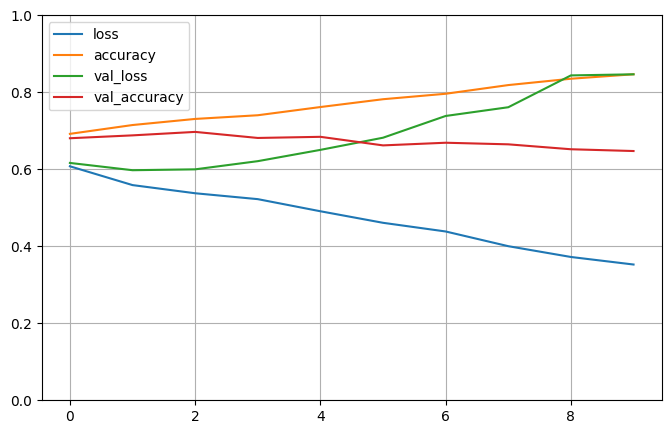

accuracy: 64.74%
Fold 3
Train set ones/size 22477 / 43451
Valid set ones/size 5625 / 10900
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1358/1358 [==============================] - 5s 3ms/step - loss: 0.6089 - accuracy: 0.6914 - val_loss: 0.5838 - val_accuracy: 0.7060
Epoch 2/10
1358/1358 [==============================] - 4s 3ms/step - loss: 0.5571 - accuracy: 0.7176 - val_loss: 0.5820 - val_accuracy: 0.7000
Epoch 3/10
1358/1358 [==============================] - 4s 3ms/step - loss: 0.5395 - accuracy: 0.7306 - val_loss: 0.5727 - val_accuracy: 0.7103
Epoch 4/10
1358/1358 [==============================] - 4s 3ms/step - loss: 0.5182 - accuracy: 0.7442 - val_loss: 0.6052 - val_accuracy: 0.6894
Epoch 5/10
1358/1358 [==============================] - 4s 3ms/step - loss: 0.4913 - accuracy: 0.7619 - val_loss: 0.6406 - val_accuracy: 0.6838
Epoch 6/10
1358/1358 [==============================] - 4s 3ms/step - loss: 0.4610 - accuracy: 0.7808 - val_loss: 0.6547 - val_accuracy: 0.6821
Epoch 

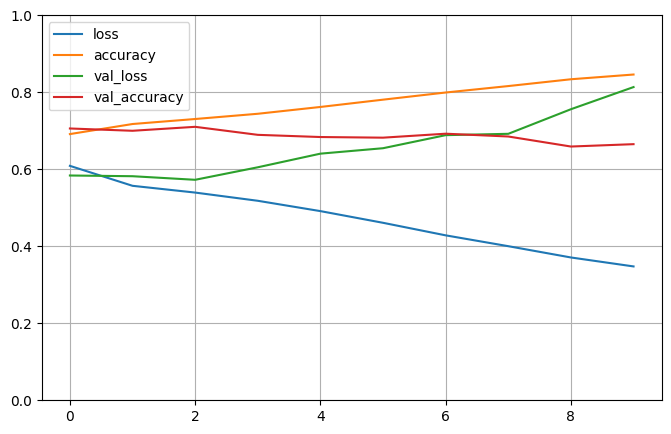

accuracy: 66.52%
Fold 4
Train set ones/size 22724 / 43564
Valid set ones/size 5320 / 10787
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.6041 - accuracy: 0.6922 - val_loss: 0.6198 - val_accuracy: 0.6699
Epoch 2/10
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5617 - accuracy: 0.7163 - val_loss: 0.6091 - val_accuracy: 0.6928
Epoch 3/10
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5440 - accuracy: 0.7287 - val_loss: 0.6182 - val_accuracy: 0.6670
Epoch 4/10
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5241 - accuracy: 0.7422 - val_loss: 0.6172 - val_accuracy: 0.6597
Epoch 5/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.4975 - accuracy: 0.7596 - val_loss: 0.6607 - val_accuracy: 0.6844
Epoch 6/10
1362/1362 [==============================] - 5s 3ms/step - loss: 0.4693 - accuracy: 0.7775 - val_loss: 0.6459 - val_accuracy: 0.6858
Epoch 

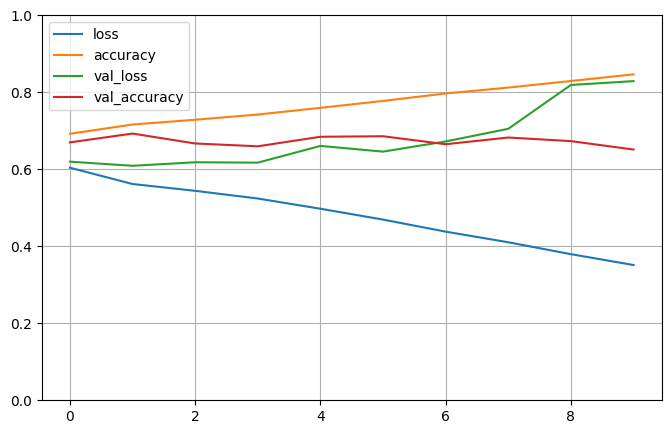

accuracy: 65.12%
Fold 5
Train set ones/size 22732 / 43835
Valid set ones/size 5297 / 10516
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
1370/1370 [==============================] - 5s 3ms/step - loss: 0.6169 - accuracy: 0.6852 - val_loss: 0.5683 - val_accuracy: 0.7044
Epoch 2/10
1370/1370 [==============================] - 4s 3ms/step - loss: 0.5670 - accuracy: 0.7111 - val_loss: 0.5657 - val_accuracy: 0.7146
Epoch 3/10
1370/1370 [==============================] - 5s 3ms/step - loss: 0.5444 - accuracy: 0.7260 - val_loss: 0.5697 - val_accuracy: 0.7079
Epoch 4/10
1370/1370 [==============================] - 4s 3ms/step - loss: 0.5247 - accuracy: 0.7387 - val_loss: 0.5700 - val_accuracy: 0.7072
Epoch 5/10
1370/1370 [==============================] - 5s 3ms/step - loss: 0.4967 - accuracy: 0.7576 - val_loss: 0.6127 - val_accuracy: 0.6977
Epoch 6/10
1370/1370 [==============================] - 4s 3ms/step - loss: 0.4677 - accuracy: 0.7771 - val_loss: 0.6239 - val_accuracy: 0.7041
Epoch 

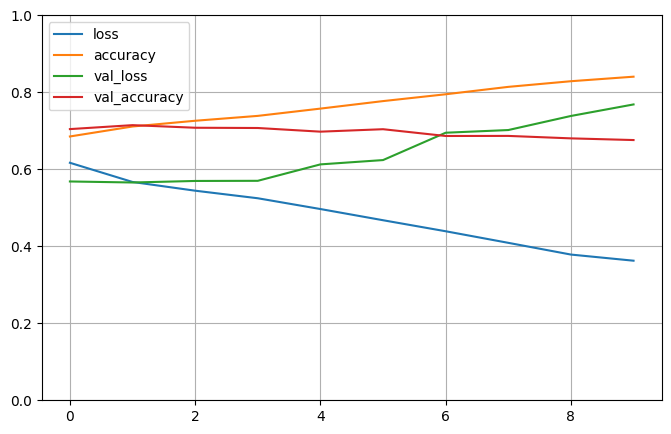

accuracy: 67.59%

Validation core mean 66.11% (+/- 1.04%)
2022-10-20 09:46:02.842264


In [9]:
# Train
print ("Cross valiation")
print(datetime.now())
do_cross_validation(splitter,EPOCHS)
print(datetime.now())